In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
from tqdm.notebook import tqdm

### Exercice 1

#### Question 1

Récupération des données et mise en forme

In [3]:
cov = pd.read_csv("hwk2_datasets\\DS1_Cov.txt", header = None, sep = ',')
m_0 = pd.read_csv("hwk2_datasets\\DS1_m_0.txt", header = None, sep = ',')
m_1 = pd.read_csv("hwk2_datasets\\DS1_m_1.txt", header = None, sep = ',')

In [4]:
cov.drop(20, axis = 1, inplace = True)
m_0.drop(20, axis = 1, inplace = True)
m_1.drop(20, axis = 1, inplace = True)

In [5]:
matrice_cov = cov.values
m_0_arr = m_0.values[0]
m_1_arr = m_1.values[0]

Création des datasets et annotation selon leur classe

In [6]:
dataset0 = np.random.multivariate_normal(m_0_arr, cov,2000)
dataset1 = np.random.multivariate_normal(m_1_arr,cov,2000)

In [7]:
dataset0_annote = []
dataset1_annote = []
for i in range(len(dataset1)):
    dataset0_annote.append(np.append(dataset0[i], -1))
    dataset1_annote.append(np.append(dataset1[i], 1))

Séparation des datasets en des datasets d'entraînement, de validation et de test

In [8]:
dataset_test = []
for i in range(400):
    j = np.random.randint(0,len(dataset0_annote))
    dataset_test.append(dataset0_annote[j])
    dataset_test.append(dataset1_annote[j])
    del dataset0_annote[j]
    del dataset1_annote[j]

In [9]:
dataset_valid = []
for i in range(400):
    j = np.random.randint(0,len(dataset0_annote))
    dataset_valid.append(dataset0_annote[j])
    dataset_valid.append(dataset1_annote[j])
    del dataset0_annote[j]
    del dataset1_annote[j]

In [10]:
dataset_train= dataset0_annote + dataset1_annote

Export des datasets obtenus

In [91]:
pd.DataFrame(dataset_train).to_csv("DS1_train.csv", sep = ';', header = None)
pd.DataFrame(dataset_valid).to_csv("DS1_valid.csv", sep = ';', header = None)
pd.DataFrame(dataset_test).to_csv("DS1_test.csv", sep = ';', header = None)

#### Question 2.a

In [13]:
#Je retire l'annotation du dataset pour en faire un vecteur à part

classes_train = []
for i in range(len(dataset_train)):
    classes_train.append(dataset_train[i][-1])
    dataset_train[i] = np.delete(dataset_train[i], -1)
    

In [14]:
#Calcul des moyennes empiriques pour les 2 classes

moyenne_emp_pos = 0
moyenne_emp_neg = 0
for i in range(len(dataset_train)):
    if classes_train[i] >= 0 :
        moyenne_emp_pos += dataset_train[i]
    else:
        moyenne_emp_neg += dataset_train[i]
moyenne_emp_pos = 2*moyenne_emp_pos/len(dataset_train)
moyenne_emp_neg = 2*moyenne_emp_neg/len(dataset_train)

In [15]:
#Calcul de la matrice de covariance empirique

cov_emp=  np.zeros((20,20))
for i in range(len(dataset_train)):
    if classes_train[i] >= 0:
        cov_emp += np.dot(np.transpose([dataset_train[i] - moyenne_emp_pos]), [dataset_train[i] - moyenne_emp_pos])
    else :
        cov_emp += np.dot( np.transpose([dataset_train[i] - moyenne_emp_neg]), [dataset_train[i] - moyenne_emp_neg])
cov_emp = cov_emp/len(dataset_train)

In [16]:
#Calcul des coefficients utiles pour la fonction logit

omega = np.dot(np.linalg.inv(cov_emp), moyenne_emp_pos - moyenne_emp_neg)
omega0 =   [moyenne_emp_neg]@np.linalg.inv(cov_emp)@np.transpose([moyenne_emp_neg]) \
            - [moyenne_emp_pos]@np.linalg.inv(cov_emp)@np.transpose([moyenne_emp_pos])
omega0 = omega0/2

In [17]:
def logit(x, seuil):
    x_copy = np.delete(x,-1)
    if omega0[0][0] + np.dot(omega.T, x_copy) >= seuil :
        return 1
    else:
        return -1

In [18]:
#Calcul du taux d'erreur sur l'ensemble de test.

compteur = 0
for i in range(len(dataset_test)):
    if logit(dataset_test[i],0) != dataset_test[i][-1]:
        compteur += 1
        
compteur = compteur / (len(dataset_test))

In [19]:
print("Précision obtenue : {}".format(1-compteur))

Précision obtenue : 0.9575


#### Question 2.b

In [25]:
pd.DataFrame(moyenne_emp_pos).to_csv("Assignment2_2160371_1_2_b_moy_1.csv", sep =';', index = None, header = None)

In [26]:
pd.DataFrame(moyenne_emp_neg).to_csv("Assignment2_2160371_1_2_b_moy_-1.csv", sep =';', index = None, header = None)

In [27]:
pd.DataFrame(cov_emp).to_csv("Assignment2_2160371_1_2_b_cov.csv", sep =';', index = None, header = None)

#### Question 3

In [28]:
def neighbors(x) :
    '''Prend en argument un vecteur x annoté ou non et renvoie la liste des distances à chaque élément 
    de l'ensemble d'entraînement trié par ordre croissant sous forme de couple (indice, distance)
    '''
    x_copy = x
    liste_distances = []
    if len(x_copy) == 21 :
        x_copy = np.delete(x_copy,-1)
    
    for i in range(len(dataset_train)):
        dist = np.linalg.norm(x_copy -dataset_train[i])
        liste_distances.append((i,dist))
        
    liste_distances.sort(key = lambda x : x[1])
    return liste_distances

In [29]:
k_values = np.arange(1,1001,1)

In [30]:
resultats_train = np.zeros((len(k_values), len(dataset_train)))


for ind_valeur in tqdm(range(len(dataset_train))):
    voisins = neighbors(dataset_train[ind_valeur])
    est_actuel = 0 #somme des i précédentes classes
    est_k = 0 #dernière valeur attribuée par le classificateur (déterminé selon le signe de est_actuel)
    i = 0
    while i < len(k_values):
        indice = voisins[i][0]
        est_actuel += classes_train[indice]
        
        if est_actuel >=0:
            est_k = 1
        else:
            est_k = -1
        resultats_train[i][ind_valeur] = (est_k * classes_train[ind_valeur] < 0)
        i += 1

    
erreur_train = [resultats_train[k].sum() / len(dataset_train) for k in range(len(k_values))]

  0%|          | 0/2400 [00:00<?, ?it/s]

In [31]:
resultats_valid = np.zeros((len(k_values), len(dataset_valid)))

for ind_valeur in tqdm(range(len(dataset_valid))):
    voisins = neighbors(dataset_valid[ind_valeur])
    est_actuel = 0
    est_k = 0
    i = 0
    while i < len(k_values):
        indice = voisins[i][0]
        est_actuel += classes_train[indice]

        if est_actuel >=0:
            est_k = 1
        else:
            est_k = -1
        resultats_valid[i][ind_valeur] = (est_k * dataset_valid[ind_valeur][-1] < 0)
        i += 1
        
erreur_valid = [resultats_valid[k].sum() / len(dataset_valid) for k in range(len(k_values))]
        

  0%|          | 0/800 [00:00<?, ?it/s]

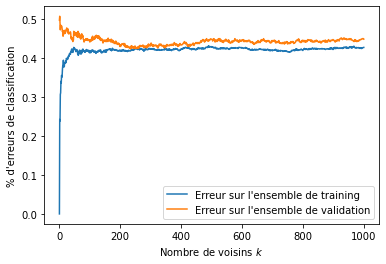

In [32]:
plt.plot(k_values, erreur_train, label = 'Erreur sur l\'ensemble de training')
plt.plot(k_values,erreur_valid, label = 'Erreur sur l\'ensemble de validation')

plt.xlabel("Nombre de voisins $k$")
plt.ylabel("% d'erreurs de classification")

plt.legend()

#### Question 3.b

In [33]:
k_opti = np.argmin(erreur_valid)

In [34]:
print(k_opti)

233


In [35]:
resultats_test = []

for ind_valeur in tqdm(range(len(dataset_test))):
    voisins = neighbors(dataset_test[ind_valeur])
    est_actuel = 0
    est_k = 0
    
    for i in range(k_opti):
        est_actuel += classes_train[voisins[i][0]]
        
    if est_actuel >= 0:
        est_k = 1
    else:
        est_k = -1
    resultats_test.append(est_k * dataset_test[ind_valeur][-1] < 0)

erreur_test = sum(resultats_test)/len(dataset_test)


  0%|          | 0/800 [00:00<?, ?it/s]

In [36]:
print("Précision obtenue : {}".format(1-erreur_test))

Précision obtenue : 0.56


#### Question 4

In [104]:
cov1 = pd.read_csv("hwk2_datasets\\DS2_Cov1.txt", header = None, sep = ',')
gauss_1_m_0 = pd.read_csv("hwk2_datasets\\DS2_c1_m1.txt", header = None, sep = ',')
gauss_1_m_1 = pd.read_csv("hwk2_datasets\\DS2_c2_m1.txt", header = None, sep = ',')

cov2 = pd.read_csv("hwk2_datasets\\DS2_Cov2.txt", header = None, sep = ',')
gauss_2_m_0 = pd.read_csv("hwk2_datasets\\DS2_c1_m2.txt", header = None, sep = ',')
gauss_2_m_1 = pd.read_csv("hwk2_datasets\\DS2_c2_m2.txt", header = None, sep = ',')

cov3 = pd.read_csv("hwk2_datasets\\DS2_Cov3.txt", header = None, sep = ',')
gauss_3_m_0 = pd.read_csv("hwk2_datasets\\DS2_c1_m3.txt", header = None, sep = ',')
gauss_3_m_1 = pd.read_csv("hwk2_datasets\\DS2_c2_m3.txt", header = None, sep = ',')

In [105]:
cov1.drop(20, axis = 1, inplace = True)
gauss_1_m_0.drop(20, axis = 1, inplace = True)
gauss_1_m_1.drop(20, axis = 1, inplace = True)

cov2.drop(20, axis = 1, inplace = True)
gauss_2_m_0.drop(20, axis = 1, inplace = True)
gauss_2_m_1.drop(20, axis = 1, inplace = True)

cov3.drop(20, axis = 1, inplace = True)
gauss_3_m_0.drop(20, axis = 1, inplace = True)
gauss_3_m_1.drop(20, axis = 1, inplace = True)

In [106]:
matrice_cov1 = cov1.values
m_0_arr1 = gauss_1_m_0.values[0]
m_1_arr1 = gauss_1_m_1.values[0]

matrice_cov2 = cov2.values
m_0_arr2 = gauss_2_m_0.values[0]
m_1_arr2 = gauss_2_m_1.values[0]

matrice_cov3 = cov3.values
m_0_arr3 = gauss_3_m_0.values[0]
m_1_arr3 = gauss_3_m_1.values[0]

In [107]:
data_g1_c0 = np.random.multivariate_normal(m_0_arr1, cov1,10*2000//100)
data_g1_c1 = np.random.multivariate_normal(m_1_arr1,cov1,10*2000//100)

data_g2_c0 = np.random.multivariate_normal(m_0_arr1, cov2,42*2000//100)
data_g2_c1 = np.random.multivariate_normal(m_1_arr1,cov2,42*2000//100)

data_g3_c0 = np.random.multivariate_normal(m_0_arr1, cov3,48*2000//100)
data_g3_c1 = np.random.multivariate_normal(m_1_arr1,cov3,48*2000//100)

In [108]:
data_c0 = np.concatenate( (np.concatenate((data_g1_c0, data_g2_c0), axis = 0) , data_g3_c0), axis = 0)
data_c1 = np.concatenate( (np.concatenate((data_g1_c1, data_g2_c1), axis = 0) , data_g3_c1), axis = 0)


In [109]:
data0_annote = []
data1_annote = []
for i in range(len(data_c0)):
    data0_annote.append(np.append(data_c0[i], -1))
    data1_annote.append(np.append(data_c1[i], 1))

In [110]:
data_test = []
for i in range(400):
    j = np.random.randint(0,len(data0_annote))
    data_test.append(data0_annote[j])
    data_test.append(data1_annote[j])
    del data0_annote[j]
    del data1_annote[j]

In [111]:
data_valid = []
for i in range(400):
    j = np.random.randint(0,len(data0_annote))
    data_valid.append(data0_annote[j])
    data_valid.append(data1_annote[j])
    del data0_annote[j]
    del data1_annote[j]

In [112]:
data_train = data0_annote + data1_annote

In [113]:
pd.DataFrame(data_train).to_csv("DS2_train.csv", sep = ';', header = None)
pd.DataFrame(data_valid).to_csv("DS2_valid.csv", sep = ';', header = None)
pd.DataFrame(data_test).to_csv("DS2_test.csv", sep = ';', header = None)

In [114]:
classes_train_mix = []
for i in range(len(data_train)):
    classes_train_mix.append(data_train[i][-1])
    data_train[i] = np.delete(data_train[i], -1)

#### Question 5.1

In [48]:
moyenne_emp_pos = 0
moyenne_emp_neg = 0
for i in range(len(data_train)):
    if classes_train_mix[i] >= 0 :
        moyenne_emp_pos += data_train[i]
    else:
        moyenne_emp_neg += data_train[i]
moyenne_emp_pos = 2*moyenne_emp_pos/len(data_train)
moyenne_emp_neg = 2*moyenne_emp_neg/len(data_train)

In [49]:
cov_emp=  np.zeros((20,20))
for i in range(len(data_train)):
    if classes_train_mix[i] >= 0:
        cov_emp += np.dot(np.transpose([data_train[i] - moyenne_emp_pos]), [data_train[i] - moyenne_emp_pos])
    else :
        cov_emp += np.dot(np.transpose([data_train[i] - moyenne_emp_neg]), [data_train[i] - moyenne_emp_neg])
cov_emp = cov_emp/len(data_train)

In [50]:
omega = np.dot(np.linalg.inv(cov_emp), moyenne_emp_pos - moyenne_emp_neg)
omega0 =   [moyenne_emp_neg]@np.linalg.inv(cov_emp)@np.transpose([moyenne_emp_neg]) \
            - [moyenne_emp_pos]@np.linalg.inv(cov_emp)@np.transpose([moyenne_emp_pos])
omega0 = omega0/2

In [51]:
def logit(x, seuil):
    x_copy = np.delete(x,-1)
    if omega0[0][0] + np.dot(omega.T, x_copy) >= seuil :
        return 1
    else:
        return -1

In [52]:
compteur = 0
for i in range(len(data_test)):
    if logit(data_test[i],0) != data_test[i][-1]:
        compteur += 1
        
compteur = compteur / (len(data_test))

In [53]:
print("Précision obtenue : {}".format(1-compteur))

Précision obtenue : 0.60625


In [54]:
pd.DataFrame(moyenne_emp_pos).to_csv("Assignment2_2160371_1_5_1_b_moy_1.csv", sep =';', index = None, header = None)

In [55]:
pd.DataFrame(moyenne_emp_pos).to_csv("Assignment2_2160371_1_5_1_b_moy_-1.csv", sep =';', index = None, header = None)

In [56]:
pd.DataFrame(cov_emp).to_csv("Assignment2_2160371_1_5_1_b_cov.csv", sep =';', index = None, header = None)

#### Question 5.2

In [57]:
def neighbors_mix(x) :
    '''Adaptation de neighbors avec un autre dataset d'entrainement
    '''
    x_copy = x
    liste_distances = []
    if len(x_copy) == 21 :
        x_copy = np.delete(x_copy,-1)
    
    for i in range(len(data_train)):
        dist = np.linalg.norm(x_copy -data_train[i])
        liste_distances.append((i,dist))
        
    liste_distances.sort(key = lambda x : x[1])
    return liste_distances

In [58]:
k_values = np.arange(1,1001,1)

In [59]:
len(k_values)

1000

In [60]:
resultats_train_mix = np.zeros((len(k_values), len(data_train)))


for ind_valeur in tqdm(range(len(data_train))):
    voisins = neighbors_mix(data_train[ind_valeur])
    est_actuel = 0
    est_k = 0
    i = 0
    while i < len(k_values) :
        indice = voisins[i][0]
        est_actuel += classes_train[indice]
        
        if est_actuel >=0 :
            est_k = 1
        else:
            est_k = -1
        resultats_train_mix[i][ind_valeur] = (est_k * classes_train_mix[ind_valeur] < 0)
        i += 1

    
erreur_train_mix = [resultats_train_mix[k].sum() / len(data_train) for k in range(len(k_values))]

  0%|          | 0/2400 [00:00<?, ?it/s]

In [61]:
resultats_valid_mix = np.zeros((len(k_values), len(data_valid)))

for ind_valeur in tqdm(range(len(data_valid))):
    voisins = neighbors_mix(data_valid[ind_valeur])
    est_actuel = 0
    est_k = 0
    i = 0
    while i < len(k_values ):
        indice = voisins[i][0]
        est_actuel += classes_train_mix[indice]

        if est_actuel >=0:
            est_k = 1
        else:
            est_k = -1
        resultats_valid_mix[i][ind_valeur] = (est_k * data_valid[ind_valeur][-1] < 0)
        i += 1
        
erreur_valid_mix = [resultats_valid_mix[k].sum() / len(data_valid) for k in range(len(k_values))]

  0%|          | 0/800 [00:00<?, ?it/s]

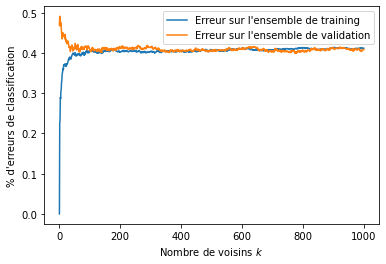

In [62]:
plt.plot(k_values, erreur_train_mix,label = 'Erreur sur l\'ensemble de training')
plt.plot(k_values, erreur_valid_mix, label = 'Erreur sur l\'ensemble de validation')

plt.xlabel("Nombre de voisins $k$")
plt.ylabel("% d'erreurs de classification")

plt.legend()

#### Question 5.3

In [67]:
k_opti = np.argmin(erreur_valid_mix)

In [68]:
print(k_opti)

774


In [65]:
resultats_test_mix = []

for ind_valeur in tqdm(range(len(data_test))):
    voisins = neighbors_mix(data_test[ind_valeur])
    est_actuel = 0
    est_k = 0
    
    for i in range(k_opti):
        est_actuel += classes_train_mix[voisins[i][0]]
        
    if est_actuel >= 0:
        est_k = 1
    else:
        est_k = -1
    resultats_test_mix.append(est_k * data_test[ind_valeur][-1] < 0)

erreur_test_mix = sum(resultats_test_mix)/len(data_test)


  0%|          | 0/800 [00:00<?, ?it/s]

In [66]:
print("Précision obtenue : {}".format(1-erreur_test_mix))

Précision obtenue : 0.55125


### Exercice 2

Import des données et mise en forme

In [132]:
#Import Keras
from tensorflow import keras
# Loading the MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [133]:
x_train_flat = np.zeros((60000,784))
for i in range(len(x_train)) :
    x_train_flat[i] = x_train[i].flatten()

In [134]:
x_test_flat = np.zeros((10000,784))
for i in range(len(x_test)) :
    x_test_flat[i] = x_test[i].flatten()

In [135]:
x_train_flat = x_train_flat/255
x_test_flat = x_test_flat/255

In [136]:
data_valid = x_train_flat[0:10000]
data_train = x_train_flat[10000:]
data_test = x_test_flat

y_valid = y_train[0:10000]
y_train = y_train[10000:]

#### Question 1

On utilise les formules présentées dans le rapport pour remonter au classificateur

In [137]:
prior = np.zeros(10)

for i in range(len(y_train)):
    prior[y_train[i]] += 1
    
prior = prior/len(y_train)

In [138]:
def log_proba_k(x,moy,var):
    '''Prend en argument un vecteur x, un vecteur de moyenne empirique de taille 10*784 et un vecteur de variances
    empiriques de taille 10*784 et renvoie un vecteur de taille 10 d'éléments P(C_k|X)
    '''
    proba = np.zeros(10)
    for k in range(10):
        matrice_proba_k = - (x - moy[k])**2 /(2* (var[k])) - np.log(var[k])/2
        proba[k] = matrice_proba_k.sum()
        proba[k] = proba[k] / prior[k]
    return proba

In [139]:
def classificateur(x,moy,var):
    '''Prend en argument un vecteur x, un vecteur de moyenne empirique de taille 10*784 et un vecteur de variances
    empiriques de taille 10*784 et renvoie la classe la plus probable pour X
    '''
    
    return np.argmax(log_proba_k(x,moy,var))

In [151]:
epsilon_values = np.arange(0.01,5000,100)
precision = []
for epsilon in tqdm(epsilon_values) :
    
    #Calcul de la moyenne empirique de chaque variable avec ce facteur epsilon
    moy_empirique = np.zeros((10,784))

    for i in range(len(data_train)):
        moy_empirique[y_train[i]] += data_train[i]
    
    for k in range(len(moy_empirique)):
        moy_empirique[k] = (moy_empirique[k] + epsilon)/(prior[k]*len(data_train))
        
    #Calcul de l'estimateur de la variance de chaque variable avec ce facteur epsilon   
    var_empirique = np.zeros((10,784))

    for i in range(len(data_train)):
        var_empirique[y_train[i]] += (data_train[i] - moy_empirique[y_train[i]])**2
    
    for k in range(len(moy_empirique)):
        var_empirique[k] = var_empirique[k]/(prior[k]*len(data_train))
    
    #Calcul de la précision sur l'ensemble de validation pour cette valeur de epsilon
    compteur = 0
    for i in range(len(data_valid)):
        if classificateur(data_valid[i],moy_empirique,var_empirique) == y_valid[i]:
            compteur += 1
    precision.append(compteur/len(data_valid))

  0%|          | 0/50 [00:00<?, ?it/s]

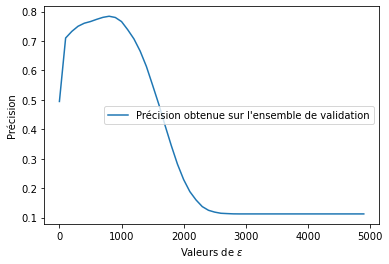

In [152]:
plt.plot(epsilon_values,precision, label = 'Précision obtenue sur l\'ensemble de validation')

plt.xlabel('Valeurs de $\epsilon$')
plt.ylabel('Précision')

plt.legend()

In [142]:
epsilon_values = np.arange(700,1100,10)
precision = []
for epsilon in tqdm(epsilon_values) :
    moy_empirique = np.zeros((10,784))

    for i in range(len(data_train)):
        moy_empirique[y_train[i]] += data_train[i]
    
    for k in range(len(moy_empirique)):
        moy_empirique[k] = (moy_empirique[k] + epsilon)/(prior[k]*len(data_train))
        
        
    var_empirique = np.zeros((10,784))

    for i in range(len(data_train)):
        var_empirique[y_train[i]] += (data_train[i] - moy_empirique[y_train[i]])**2
    
    for k in range(len(moy_empirique)):
        var_empirique[k] = var_empirique[k]/(prior[k]*len(data_train))
    
    compteur = 0
    for i in range(len(data_valid)):
        if classificateur(data_valid[i],moy_empirique,var_empirique) == y_valid[i]:
            compteur += 1
    precision.append(compteur/len(data_valid))

  0%|          | 0/40 [00:00<?, ?it/s]

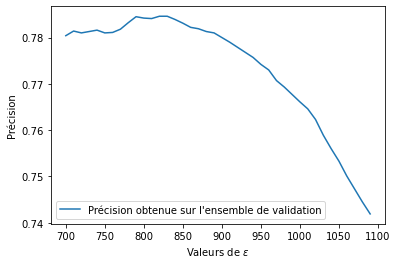

In [143]:
plt.plot(epsilon_values,precision, label = 'Précision obtenue sur l\'ensemble de validation')

plt.xlabel('Valeurs de $\epsilon$')
plt.ylabel('Précision')

plt.legend()

In [144]:
print("La valeur optimale de epsilon est {}".format(epsilon_values[np.argmax(precision)]))

La valeur optimale de epsilon est 820


In [145]:
epsilon = epsilon_values[np.argmax(precision)]

moy_empirique = np.zeros((10,784))
for i in range(len(data_train)):
    moy_empirique[y_train[i]] += data_train[i]

for k in range(len(moy_empirique)):
    moy_empirique[k] = (moy_empirique[k] + epsilon)/(prior[k]*len(data_train))


var_empirique = np.zeros((10,784))
for i in range(len(data_train)):
    var_empirique[y_train[i]] += (data_train[i] - moy_empirique[y_train[i]])**2

for k in range(len(moy_empirique)):
    var_empirique[k] = var_empirique[k]/(prior[k]*len(data_train))
    


In [146]:
compteur = 0
for i in range(len(data_test)):
    if classificateur(data_test[i],moy_empirique,var_empirique) == y_test[i]:
        compteur += 1
compteur = compteur/len(data_test)

In [147]:
print("La précision obtenue est de {}".format(compteur))

La précision obtenue est de 0.7908


In [148]:
pd.DataFrame(prior).to_csv("Assignment2_2160371_2_1_b_prior.csv", sep = ';', index = None, header = None)

In [149]:
pd.DataFrame(moy_empirique).to_csv("Assignment2_2160371_2_1_b_moy.csv", sep = ';', index = None, header = None)

In [150]:
pd.DataFrame(var_empirique).to_csv("Assignment2_2160371_2_1_b_var.csv", sep = ';', index = None, header = None)

#### Question 2.a

In [153]:
def neighbors_mnist(x) :
    x_copy = x
    liste_distances = []
    for i in range(len(data_train)):
        dist = np.linalg.norm(x_copy - data_train[i])
        liste_distances.append((i,dist))
    liste_distances.sort(key = lambda x : x[1])
    return liste_distances

In [154]:
k_values = np.arange(1,10001,10)

In [156]:
#Attention, temps d'exécution de 3h30

'''resultats_train_mnist = np.zeros((len(k_values), len(data_train)))


for ind_valeur in tqdm(range(len(data_train))):
    voisins = neighbors_mnist(data_train[ind_valeur])
    est_actuel = np.zeros(10)
    est_k = 0
    i = 0
    while i < 10000 :
        indice = voisins[i][0]
        est_actuel[y_train[indice]] += 1 
        if i%10 == 0:
            est_k = np.argmax(est_actuel)
            resultats_train_mnist[i//10][ind_valeur] = (est_k != y_train[ind_valeur])
        
        i += 1

    
erreur_train_mnist = [resultats_train_mnist[k].sum() / len(data_train) for k in range(len(k_values))] '''

'resultats_train_mnist = np.zeros((len(k_values), len(data_train)))\n\n\nfor ind_valeur in tqdm(range(len(data_train))):\n    voisins = neighbors_mnist(data_train[ind_valeur])\n    est_actuel = np.zeros(10)\n    est_k = 0\n    i = 0\n    while i < 10000 :\n        indice = voisins[i][0]\n        est_actuel[y_train[indice]] += 1 \n        if i%10 == 0:\n            est_k = np.argmax(est_actuel)\n            resultats_train_mnist[i//10][ind_valeur] = (est_k != y_train[ind_valeur])\n        \n        i += 1\n\n    \nerreur_train_mnist = [resultats_train_mnist[k].sum() / len(data_train) for k in range(len(k_values))] '

In [317]:
#Attention, temps d'exécution de 45mn


resultats_valid_mnist = np.zeros((len(k_values), len(data_valid)))


for ind_valeur in tqdm(range(len(data_valid))):
    voisins = neighbors_mnist(data_valid[ind_valeur])
    est_actuel = np.zeros(10)
    est_k = 0
    i = 0
    while i < 10000 :
        indice = voisins[i][0]
        est_actuel[y_train[indice]] += 1 
        if i%10 == 0:
            est_k = np.argmax(est_actuel)
            resultats_valid_mnist[i//10][ind_valeur] = (est_k != y_valid[ind_valeur])
        
        i += 1

    
erreur_valid_mnist = [resultats_valid_mnist[k].sum() / len(data_valid) for k in range(len(k_values))]

  0%|          | 0/10000 [00:00<?, ?it/s]

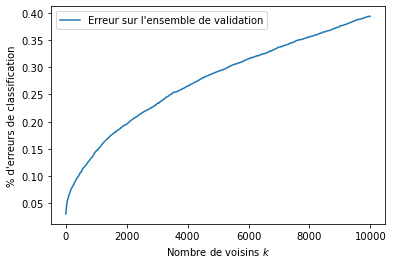

In [320]:
#plt.plot(k_values, erreur_train_mnist,label = 'Erreur sur l\'ensemble de training')
plt.plot(k_values, erreur_valid_mnist, label = 'Erreur sur l\'ensemble de validation')

plt.xlabel("Nombre de voisins $k$")
plt.ylabel("% d'erreurs de classification")

plt.legend()

#### Question 2.b

In [162]:
#k_opti = 1+ 10*np.argmin(erreur_valid_mnist)


In [160]:
def classificateur_1nn_mnist(x):
    min_dist = 10**10
    indmin = 0
    for i in range(len(data_train)):
        dist = np.linalg.norm(x - data_train[i])
        if dist<= min_dist:
            indmin = i
            min_dist = dist
    return y_train[indmin]

In [161]:
succes=0

for i in tqdm(range(len(data_test))):
    succes += (classificateur_1nn_mnist(data_test[i]) == y_test[i])

succes = succes/len(data_test)
print(succes)

  0%|          | 0/10000 [00:00<?, ?it/s]

0.9669


In [163]:
print("Précision obtenue sur l'ensemble de test : {}".format(succes))

Précision obtenue sur l'ensemble de test : 0.9669
